# Joint modeling of neural and behavioural dynamics during perturbed center-out reaches

In this example, we will show how to use a forced latentsde model to generate neural observations (spiking recordings in Area 2) and behavioural observations (Hand position) of a monkey doing a center-out reach task. In some of the trials the monkey is perturbed by a force field. The force field is provided as an input to the model. 

The data is available for download [here](https://dandiarchive.org/#/dandiset/000128).


In [1]:
using Pkg, Revise, Lux, LuxCUDA, CUDA, Random, DifferentialEquations, SciMLSensitivity, ComponentArrays, Plots, MLUtils, OptimizationOptimisers, LinearAlgebra, Statistics, Printf, PyCall, Distributions
using IterTools: ncycle
using NeuroDynamics
np = pyimport("numpy")
device = "cpu"
const dev = device == "gpu" ? gpu_device() : cpu_device()


(::LuxCPUDevice) (generic function with 5 methods)

## 1. Loading the data and creating the dataloaders

You can prepare the data yourself or use our preprocessed data staright away which is available [here](https://drive.google.com/file/d/1J9)

In [2]:
file_path = "/Users/ahmed.elgazzar/Datasets/NLB/area2_bump.npy" # change this to the path to the dataset
data = np.load(file_path, allow_pickle=true)
U = permutedims(get(data[1], "force") , [3, 2, 1])
Y_neural = permutedims(get(data[1], "spikes") , [3, 2, 1])
Y_behaviour = permutedims(get(data[1], "hand_pos") , [3, 2, 1])
n_neurons , n_timepoints, n_trials = size(Y_neural);
n_behviour = size(Y_behaviour)[1] 
n_control = size(U)[1]
ts = range(0, 4, length=n_timepoints);
(U_train, Yn_train, Yb_train) , (U_test, Yn_test, Yb_test) = splitobs((U, Y_neural, Y_behaviour); at=0.8)
train_loader = DataLoader((U_train, Yn_train, Yb_train), batchsize=32, shuffle=true)
val_loader = DataLoader((U_test, Yn_test, Yb_test), batchsize=10, shuffle=true);

## 2. Defining the model 
- We will use a "Recurrent_Encoder" to infer the initial hidden state from a portion of the observations. 
- We will use a modern intepertation of the Wilson Cowan model with multiplicative noise to model the latent dynamics.
- We will use a multi-headed decoder, one for the neural observations and one for behaviour.

In [3]:
hp = Dict("n_states" => 16, "hidden_dim" => 64, "context_dim" => 32, "t_init" => Int(0.5 * n_timepoints))
rng = Random.MersenneTwister(1234)
obs_encoder = Recurrent_Encoder(n_neurons, hp["n_states"], hp["context_dim"], 32, hp["t_init"])
drift = ModernWilsonCowan(hp["n_states"], n_control)
drift_aug = Chain(Dense(hp["n_states"] + hp["context_dim"] + n_control, hp["hidden_dim"], relu), Dense(hp["hidden_dim"], hp["n_states"],tanh))
diffusion = Scale(hp["n_states"], sigmoid)
dynamics = SDE(drift, drift_aug, diffusion, EulerHeun(), saveat=ts, dt=ts[2]-ts[1])
obs_decoder = Chain(MLP_Decoder(hp["n_states"], n_neurons, 64, 1, "Poisson"), Lux.BranchLayer(NoOpLayer(), Linear_Decoder(n_neurons, n_behviour,"Gaussian")))
ctrl_encoder, ctrl_decoder = NoOpLayer(), NoOpLayer()
model = LatentUDE(obs_encoder, ctrl_encoder, dynamics, obs_decoder, ctrl_decoder, dev)

p, st = Lux.setup(rng, model)
p = p |> ComponentArray{Float32};


## 3. Training the model 

We will train the model using the AdamW optimizer with a learning rate of 1e-3 for 200 epochs. 


In [4]:
function train(model::LatentUDE, p, st, train_loader, val_loader, epochs, print_every)
    
    epoch = 0
    L = frange_cycle_linear(epochs+1, 0.5f0, 1.0f0, 1, 0.5)
    losses = []
    θ_best = nothing
    best_metric = -Inf
    println("Training ...")

    function loss(p, u, y_n, y_b)
        (ŷ_n, ŷ_b), _, x̂₀, kl_path = model(y_n, u, ts, p, st)
        batch_size = size(y_n)[end]
        neural_loss = - poisson_loglikelihood(ŷ_n, y_n)/batch_size
        behaviorual_loss = - normal_loglikelihood(ŷ_b..., y_b)
        obs_loss = neural_loss + behaviorual_loss
        kl_init = kl_normal(x̂₀[1], x̂₀[2])
        kl_path = mean(kl_path[end,:])
        kl_loss =  kl_path  +  kl_init
        l =  0.5*obs_loss + L[epoch+1]*kl_loss
        return l, obs_loss, kl_loss
    end


    callback = function(opt_state, l, obs_loss , kl_loss)
        θ = opt_state.u
        push!(losses, l)
        if length(losses) % length(train_loader) == 0
            epoch += 1
        end

        if length(losses) % (length(train_loader)*print_every) == 0
            @printf("Current epoch: %d, Loss: %.2f, Observations_loss: %d, KL: %.2f\n", epoch, losses[end], obs_loss, kl_loss)
            u, y_n, y_b = first(val_loader) 
            (ŷ_n, ŷ_b), _, _ = predict(model, y_n, u, ts, θ, st, 20) 
            ŷ_n = dropdims(mean(ŷ_n, dims=4), dims=4)
            ŷ_b_m, ŷ_b_s = dropdims(mean(ŷ_b[1], dims=4), dims=4), dropdims(mean(ŷ_b[2], dims=4), dims=4)
            val_bps = bits_per_spike(ŷ_n, y_n)
            val_ll = normal_loglikelihood(ŷ_b_m, ŷ_b_s, y_b)
            @printf("Validation bits/spike: %.2f\n", val_bps)
            @printf("Validation behaviour log-likelihood: %.2f\n", val_ll)
            if val_ll > best_metric
                best_metric = val_ll
                 θ_best = copy(θ)
                @printf("Saving best model \n")
            end   
            d = plot_ci(y_b,  ŷ_b..., 1.96)
            display(d)

        end
        return false
    end

    adtype = Optimization.AutoZygote()
    optf = OptimizationFunction((p, _ , u, y_n, y_b) -> loss(p, u, y_n, y_b), adtype)
    optproblem = OptimizationProblem(optf, p)
    result = Optimization.solve(optproblem, ADAMW(1e-3), ncycle(train_loader, epochs); callback)
    return model, θ_best
    
end


train (generic function with 1 method)

Training ...
Current epoch: 200, Loss: 8492.93, Observations_loss: 16664, KL: 268.09
Validation bits/spike: -8.79
Validation behaviour log-likelihood: -15994.55
Saving best model 
Current epoch: 400, Loss: 7979.55, Observations_loss: 15550, KL: 292.52
Validation bits/spike: -5.23
Validation behaviour log-likelihood: -15233.92
Saving best model 
Current epoch: 600, Loss: 5092.40, Observations_loss: 9202, KL: 614.64
Validation bits/spike: -3.22
Validation behaviour log-likelihood: -12688.36
Saving best model 
Current epoch: 800, Loss: 3245.52, Observations_loss: 4947, KL: 858.47
Validation bits/spike: -2.79
Validation behaviour log-likelihood: -16818.52
Current epoch: 1000, Loss: 2216.06, Observations_loss: 2485, KL: 974.36
Validation bits/spike: -2.59
Validation behaviour log-likelihood: -35573.68
Current epoch: 1200, Loss: 1648.91, Observations_loss: 979, KL: 1159.61
Validation bits/spike: -2.14
Validation behaviour log-likelihood: -55243.26
Current epoch: 1400, Loss: 1313.22, Observat

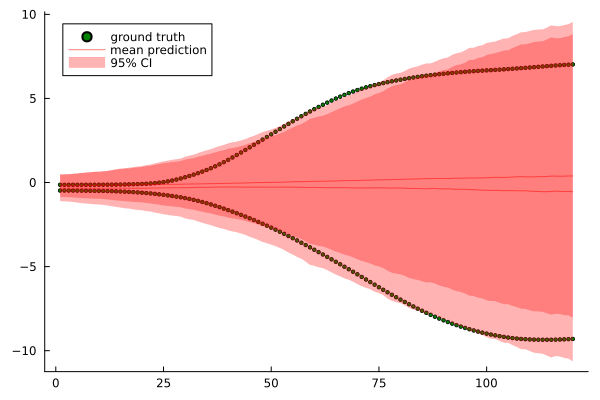

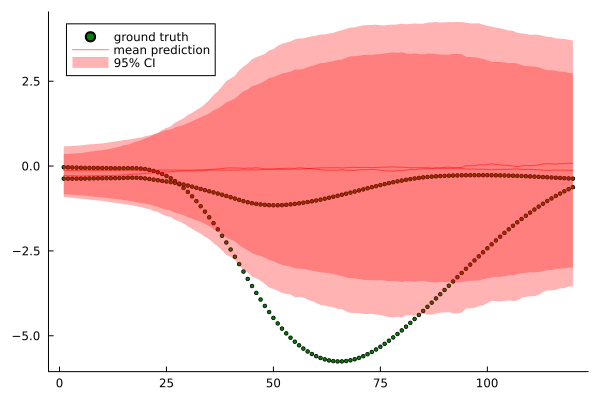

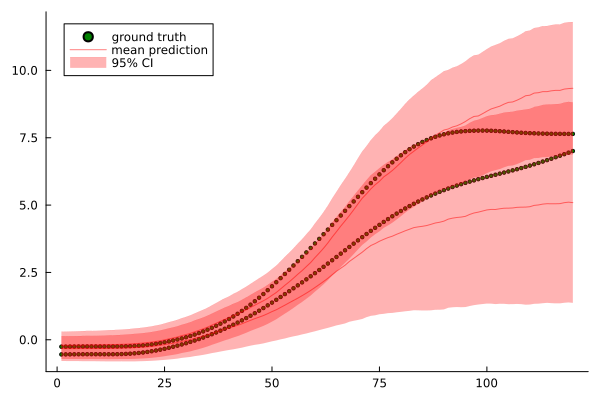

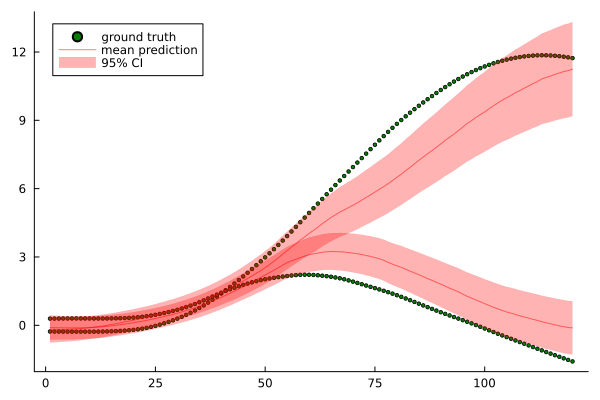

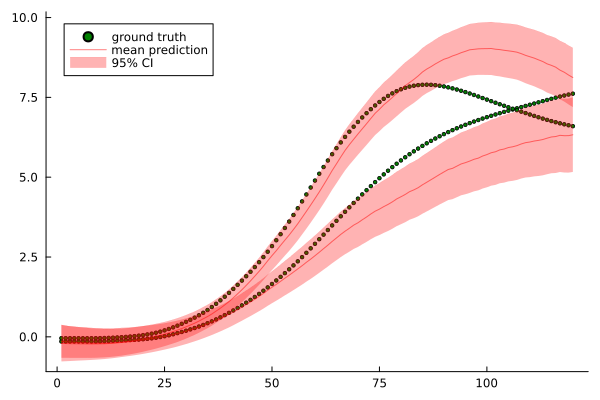

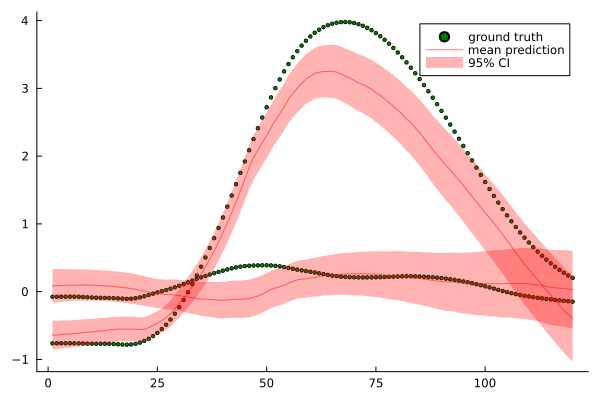

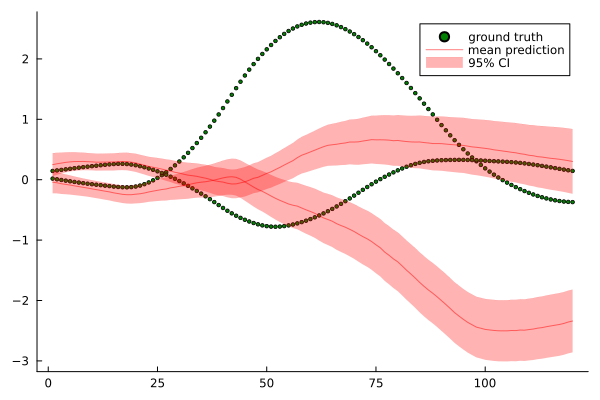

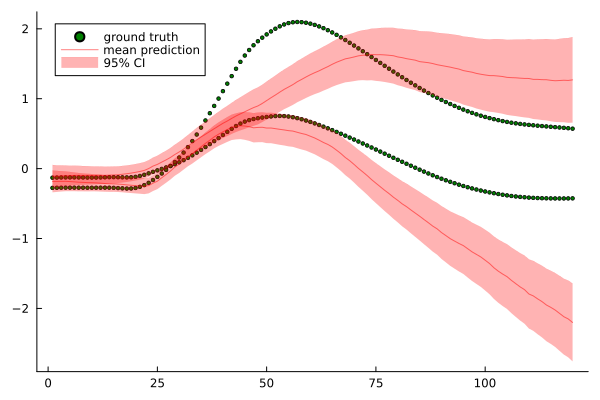

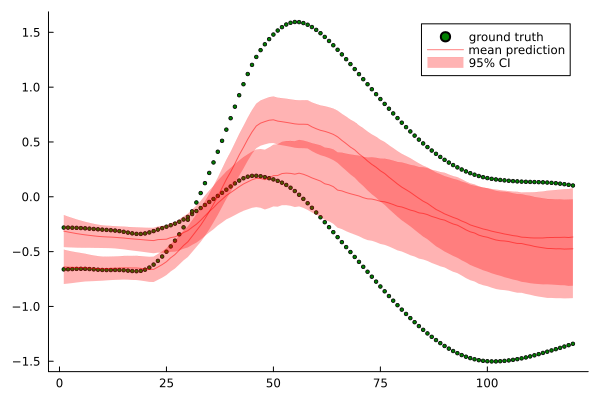

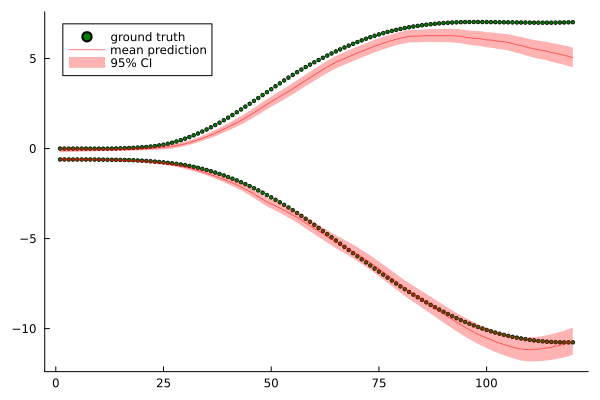

┌ Warning: /Users/ahmed.elgazzar/Code/MyPackages/NeuroDynamics/NeuroDynamics/src/systems is not an existing directory, Revise is not watching
└ @ Revise /Users/ahmed.elgazzar/.julia/packages/Revise/W4D4d/src/packagedef.jl:573


In [5]:
model, θ_best = train(model, p, st, train_loader, val_loader, 5000, 500);

Validation bits/spike: -3.68


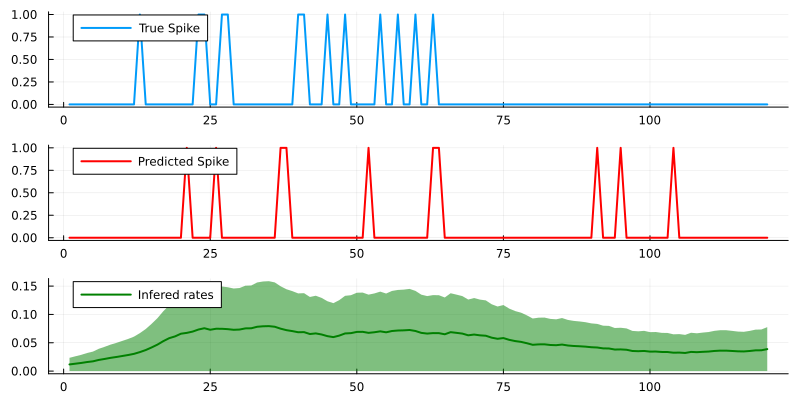

In [9]:
u, y_n, y_b = first(test_loader) 
(ŷ_n, ŷ_b), _, x = predict(model, y_n, u, ts, θ_best, st, 20)
sample = 2
ch = 15
ŷₘ = dropmean(ŷ_n, dims=4)
ŷₛ = dropmean(ŷ_n, dims=4)
dist = Poisson.(ŷₘ)
pred_spike = rand.(dist)
xₘ = dropmean(x, dims=4)
val_bps = bits_per_spike(ŷₘ, y_n)

p1 = plot(transpose(y_n[ch:ch,:,sample]), label="True Spike", lw=2)
p2 = plot(transpose(pred_spike[ch:ch,:,sample]), label="Predicted Spike", lw=2, color="red")
p3 = plot(transpose(ŷₘ[ch:ch,:,sample]), ribbon=transpose(ŷₛ[ch:ch,:,sample]), label="Infered rates", lw=2, color="green")
@printf("Validation bits/spike: %.2f\n", val_bps)

plot(p1, p2,p3, layout=(3,1), size=(800, 400), legend=:topleft)
